In [4]:
from __future__ import print_function, division

from keras.datasets import mnist
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Activation, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, Lambda
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adadelta
from keras import losses, activations
from keras.utils import to_categorical
import keras.backend as K
from keras.utils.vis_utils import plot_model
import scipy
import tensorflow as tf


import matplotlib.pyplot as plt

import numpy as np
from dataread import DataRead

In [5]:
def weightedMSELoss(y_true, y_pred):
    masked_difference = np.multiply(y_true[:,:,:,:,3] * (y_true[:,:,:,:,:3] - y_pred))
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

In [6]:
def generatorAdversarialLoss(y_true, y_pred):
        real = y_pred[:, 0]
        fake = y_pred[:, 1]
        loss_real = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real, labels=tf.zeros_like(real)))
        loss_fake = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake, labels=tf.ones_like(fake)))
        loss = loss_real + loss_fake
        # loss = util.tfprint(loss, "discriminator_loss")
        return loss

In [7]:
def discriminatorAdversarialLoss(y_true, y_pred):
        real = y_pred[:, 0]
        fake = y_pred[:, 1]
        loss_real = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real, labels=tf.ones_like(real)))
        loss_fake = K.mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake, labels=tf.zeros_like(fake)))
        loss = loss_real + loss_fake
        # loss = util.tfprint(loss, "discriminator_loss")
        return loss

In [31]:
class GANScape():
    def __init__(self, batchSize=32, inputImgShape=(64,64,3), localDiscInputShape=(28,28,3)):
        #self.imgHeight = 64
        #self.imgWidth = 64
        #self.channels = 4
        self.batchSize = batchSize
        self.inputImgShape = inputImgShape
        self.localDiscInputShape = localDiscInputShape
        self.weightForAdversarialInJointLoss = 0.1
        
        optimizer = Adadelta()
        
        #self.generator = self.buildGenerator() 
        #self.discriminator = self.buildDiscriminator()
        
        #self.combinedForPhaseTwo = Model(self.generator, self.discriminator)
        
        #compile network
        #self.generatorWithMSE.compile(optimizer=optimizer, loss=weightedMSELoss)
        #self.generatorWithJointLoss.compile(optimizer=optimizer, loss=['binary_crossentropy', weightedMSELoss], loss_weights=[self.weightForJointLossInGenerator, 1-self.weightForJointLossInGenerator])
        #self.discriminator.compile(optimizer=optimizer, loss=['binary_crossentropy'])
        
        #self.trainData = DataRead(r'C:\\places\\','train',25,5)#path, mode, batch size, batch num  folder_path, data_type, batch_size, batch_num)
    
        
        self.compileGenerator()
        self.compileAll()
        
        """

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['mse', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        

        # The generator takes noise as input and generates imgs
        masked_img = Input(shape=self.img_shape)
        gen_img = self.generator(masked_img)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid, _ = self.discriminator(gen_img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(masked_img , valid)
        self.combined.compile(loss=['mse'],
            optimizer=optimizer)
        """

        
    def compileModel(self, model, losses, optimizer, lossWeights=None):
        if lossWeights is None:
            model.compile(loss = losses,optimizer = optimizer)
        else:
            model.compile(loss = losses,optimizer = optimizer, loss_weights=lossWeights)
        return model
    


    #def buildGenerator(self, inputImageLayer, inputMaskLayer):
    def buildGenerator(self, inputImageLayer):
        gen = Conv2D(64, kernel_size=(5, 5), padding='same')(inputImageLayer)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        gen = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(128, kernel_size=(3, 3), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        gen = Conv2D(256, kernel_size=(3, 3), strides=(2,2), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256, kernel_size=(3, 3), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256, kernel_size=(3, 3), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        gen = Conv2D(256, kernel_size=(3, 3), dilation_rate=(2, 2), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256, kernel_size=(3, 3), dilation_rate=(4, 4), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256, kernel_size=(3, 3), dilation_rate=(8, 8), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(256, kernel_size=(3, 3), dilation_rate=(16, 16), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        gen = Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(128, kernel_size=(3, 3), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        gen = Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        gen = Conv2D(32, kernel_size=(3, 3), padding='same')(gen)
        gen = ReLU()(gen)
        gen = BatchNormalization()(gen)
        
        genOutput = Conv2D(3, kernel_size=(3, 3), padding='same')(gen)
        #genOutput = Activation(activations.sigmoid)(genOutput)
        
        #return Model([inputImageLayer, inputMaskLayer], genOutput)
        return Model(inputImageLayer, genOutput)
       
        
    def buildDiscriminator(self, globalDiscInput, localDiscInput):
        globalDisc = Conv2D(64, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDiscInput)
        globalDisc = ReLU()(globalDisc)
        globalDisc = BatchNormalization()(globalDisc)
        globalDisc = Conv2D(128, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDisc)
        globalDisc = ReLU()(globalDisc)
        globalDisc = BatchNormalization()(globalDisc)
        globalDisc = Conv2D(256, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDisc)
        globalDisc = ReLU()(globalDisc)
        globalDisc = BatchNormalization()(globalDisc)
        globalDisc = Conv2D(512, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDisc)
        globalDisc = ReLU()(globalDisc)
        globalDisc = BatchNormalization()(globalDisc)
        globalDisc = Conv2D(512, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDisc)
        globalDisc = ReLU()(globalDisc)
        globalDisc = BatchNormalization()(globalDisc)
        globalDisc = Conv2D(512, kernel_size=(5, 5), strides=(2,2), padding='same')(globalDisc)
        globalDisc = ReLU()(globalDisc)

        globalDisc = Flatten()(globalDisc)
        globalDisc = Dense(1024)(globalDisc)
        
        
        
        localDisc = Conv2D(64, kernel_size=(5, 5), strides=(2,2), padding='same')(localDiscInput)
        localDisc = ReLU()(localDisc)
        localDisc = BatchNormalization()(localDisc)
        localDisc = Conv2D(128, kernel_size=(5, 5), strides=(2,2), padding='same')(localDisc)
        localDisc = ReLU()(localDisc)
        localDisc = BatchNormalization()(localDisc)
        localDisc = Conv2D(256, kernel_size=(5, 5), strides=(2,2), padding='same')(localDisc)
        localDisc = ReLU()(localDisc)
        localDisc = BatchNormalization()(localDisc)
        localDisc = Conv2D(512, kernel_size=(5, 5), strides=(2,2), padding='same')(localDisc)
        localDisc = ReLU()(localDisc)
        localDisc = BatchNormalization()(localDisc)
        localDisc = Conv2D(512, kernel_size=(5, 5), strides=(2,2), padding='same')(localDisc)
        localDisc = ReLU()(localDisc)
        
        localDisc = Flatten()(localDisc)
        localDisc = Dense(1024)(localDisc)
        
        
        concatedDisc = Concatenate()([globalDisc, localDisc])
        concatedDisc = Dense(1)(concatedDisc)
        genOutput = Activation(activations.sigmoid)(concatedDisc)
        
        return Model(inputs=[globalDiscInput, localDiscInput], outputs=concatedDisc)


    def compileGenerator(self):
        #define inputs
        genInputShape = (self.inputImgShape[0], self.inputImgShape[1], self.inputImgShape[2]+1)
        inputImgGen = Input(genInputShape, name='input_image_layer_for_generator')
        #inputImgGen = Input(self.inputImgShape, name='input_image_layer_for_generator')
        #inputBinMaskGen = Input(self.inputImgShape[:2], name='input_binary_mask_layer_for_generator')
        
        #build and compile generator
        #generator = self.buildGenerator(inputImgGen, inputBinMaskGen)
        generator = self.buildGenerator(inputImgGen)
        compiledGenerator = self.compileModel(generator, 'mean_squared_error', Adadelta())
        return compiledGenerator, generator
    
    
    def cropLocalDiscInputFromImg(self, realImgs, fakeImgs, maskParams):
        realImgs = tf.split(realImgs, self.batchSize)
        fakeImgs = tf.split(fakeImgs, self.batchSize)
        maskParams = tf.split(maskParams, self.batchSize)
        realLocalInputs = []
        fakeLocalInputs = []
        for real, fake, maskParam in zip(realImgs, fakeImgs, maskParams):
            # １次元目のバッチを示す次元を削除
            fake = K.squeeze(fake, 0)
            real = K.squeeze(real, 0)
            maskParam = K.cast(K.squeeze(maskParam, 0), tf.int32)
            
            top = maskParam[0]
            left = maskParam[1]
            h = maskParam[2] - top
            w = maskParam[3] - left
            yCenter = (top + h) // 2
            xCenter = (left + w) // 2
            yStart = yCenter - (self.localDiscInputShape[0] // 2)
            xStart = xCenter - (self.localDiscInputShape[1] // 2)

            realImgLocalInput = tf.image.crop_to_bounding_box(
                real, yStart, xStart, self.localDiscInputShape[0], self.localDiscInputShape[1])
            realLocalInputs.append(realImgLocalInput)
            
            fakeImgLocalInput = tf.image.crop_to_bounding_box(
                fake, yStart, xStart, self.localDiscInputShape[0], self.localDiscInputShape[1])
            fakeLocalInputs.append(fakeImgLocalInput)

        realLocalInputs = K.stack(realLocalInputs)
        fakeLocalInputs = K.stack(fakeLocalInputs)
        # print("real_locals, fake_locals", real_locals, fake_locals)
        return [realLocalInputs,  fakeLocalInputs]
        
    
    
    def compileAll(self):
        #define inputs
        genInputShape = (self.inputImgShape[0], self.inputImgShape[1], self.inputImgShape[2]+1)
        inputImgGen = Input(genInputShape, name='input_image_layer_for_generator')
        #inputImgGen = Input(shape=self.inputImgShape, name='input_image_layer_for_generator')
        #inputBinMaskGen = Input(shape=self.inputImgShape[:2], name='input_binary_mask_layer_for_generator')
        
        maskParamsInputLocalDisc = Input(shape=4, name='input_mask_params_for_local_disc')
        realInputLocalDisc = Input(shape=self.localDiscInputShape, name='input_real_mask_img_for_local_disc')
        
        realInputGlobalDisc = Input(shape=self.inputImgShape, name='input_real_img_for_global_disc')
        
        #build models
        #generator = self.buildGenerator(inputImgGen, inputBinMaskGen)
        generator = self.buildGenerator(inputImgGen)
        discriminator = self.buildDiscriminator(realInputGlobalDisc, realInputLocalDisc)
        
        fakeInputGlobalDisc = generator.layers[-1].output
    
        """
        if freezeGenerator:
            # Weight of Generator is fixed.
            outputs = []
            losses = []
        else:
            outputs = [fakeInputGlobalDisc]
            losses = ['mean_squared_error']
        """

        # Genuine, let the discriminator evaluate the fake produced by the generator
        # local image is cut out from the mask area image and evaluated
        #discriminator.summary()
        realInputLocalDisc, fakeInputLocalDisc = Lambda(lambda x: self.cropLocalDiscInputFromImg(*x),name='crop_local_disc_input_from_img')([realInputGlobalDisc, fakeInputGlobalDisc, maskParamsInputLocalDisc])
        realProb = discriminator([realInputGlobalDisc, realInputLocalDisc])
        fakeProb = discriminator([fakeInputGlobalDisc, fakeInputLocalDisc])
        
        #print("prob_real: ", realProb)
        #print("prob_fake: ", fakeProb)
        def _stack(pReal, pFake):
            prob = K.squeeze(K.stack([pReal, pFake], -1), 1)
            #print(prob)
            return prob
        probs = Lambda(lambda x: _stack(*x), name='stack_prob')([realProb, fakeProb])
        # print("prob: ", prob)
        
        outputsForOnlyDisc = [probs]
        lossesForOnlyDisc = [discriminatorAdversarialLoss]
        outputsForOnlyGenJoint = [fakeInputGlobalDisc, probs]
        lossesForOnlyGenJoint = ['mean_squared_error', generatorAdversarialLoss]
        lossWeightForOnlyGenJoint = [1, self.weightForAdversarialInJointLoss]
        
        ########################################################x
        #COMPILE TRAINING MODELS
        
        #this is generator: Model(inputImageLayer, genOutput)
        combinedModelTrainOnlyDisc = Model([inputImgGen, maskParamsInputLocalDisc, realInputGlobalDisc], outputsForOnlyDisc)
        combinedModelTrainOnlyGenWithJoint = Model([inputImgGen, maskParamsInputLocalDisc, realInputGlobalDisc], outputsForOnlyGenJoint)
        
        self.modelForTrainOnlyGenWithMSE = self.compileModel(generator, 'mean_squared_error', Adadelta())
        
        for layer in generator.layers:
            layer.trainable = False
        self.modelForTrainOnlyDisc = self.compileModel(combinedModelTrainOnlyDisc, lossesForOnlyDisc, Adadelta())
        
        for layer in generator.layers:
            layer.trainable = True
        for layer in discriminator.layers:
            layer.trainable = False
        self.modelForTrainOnlyGenWithJoint = self.compileModel(combinedModelTrainOnlyGenWithJoint, lossesForOnlyGenJoint, Adadelta(), lossWeights=lossWeightForOnlyGenJoint)
        
        #self.compiledCombinedModel = self.compileModel(combinedModel, losses, Adadelta())
        #return combinedModel, compiledCombinedModel
    

In [32]:
net = GANScape(32)
net.compileAll()

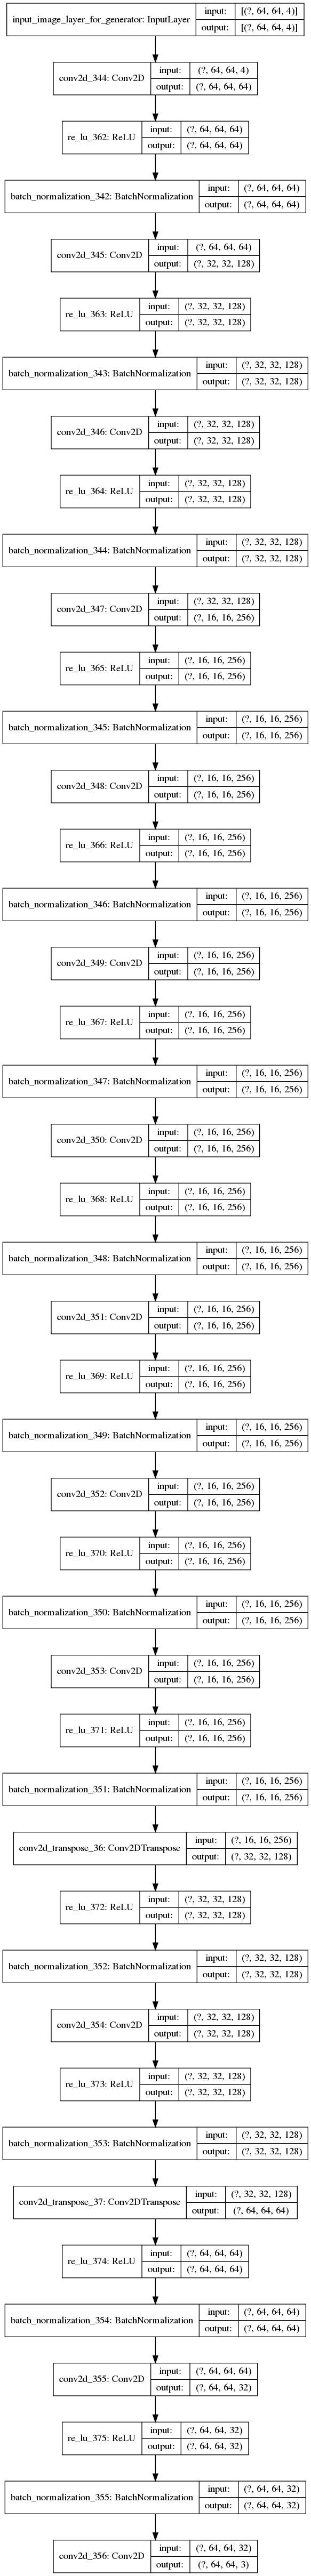

In [33]:
plot_model(net.modelForTrainOnlyGenWithMSE, to_file='modelForTrainOnlyGenWithMSE.png', show_shapes=True, show_layer_names=True)

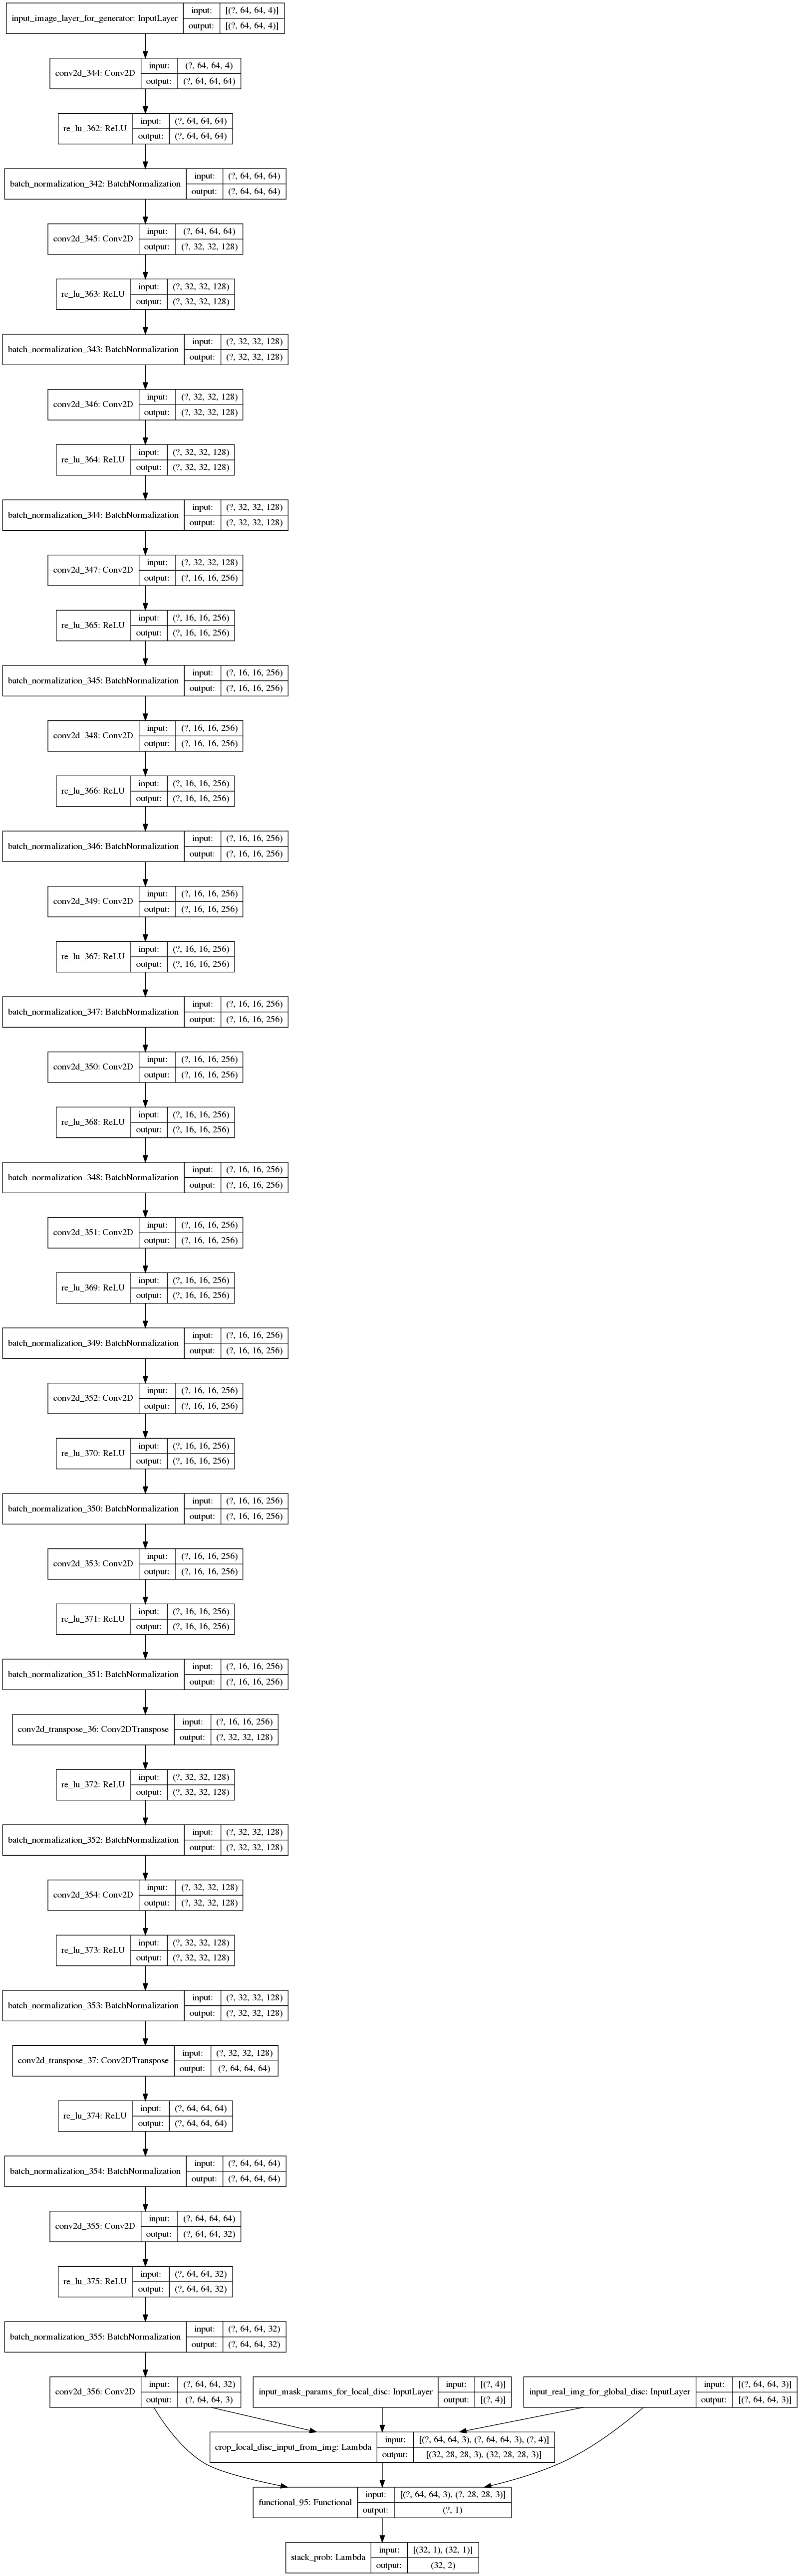

In [34]:
plot_model(net.modelForTrainOnlyDisc, to_file='modelForTrainOnlyDisc.png', show_shapes=True, show_layer_names=True)

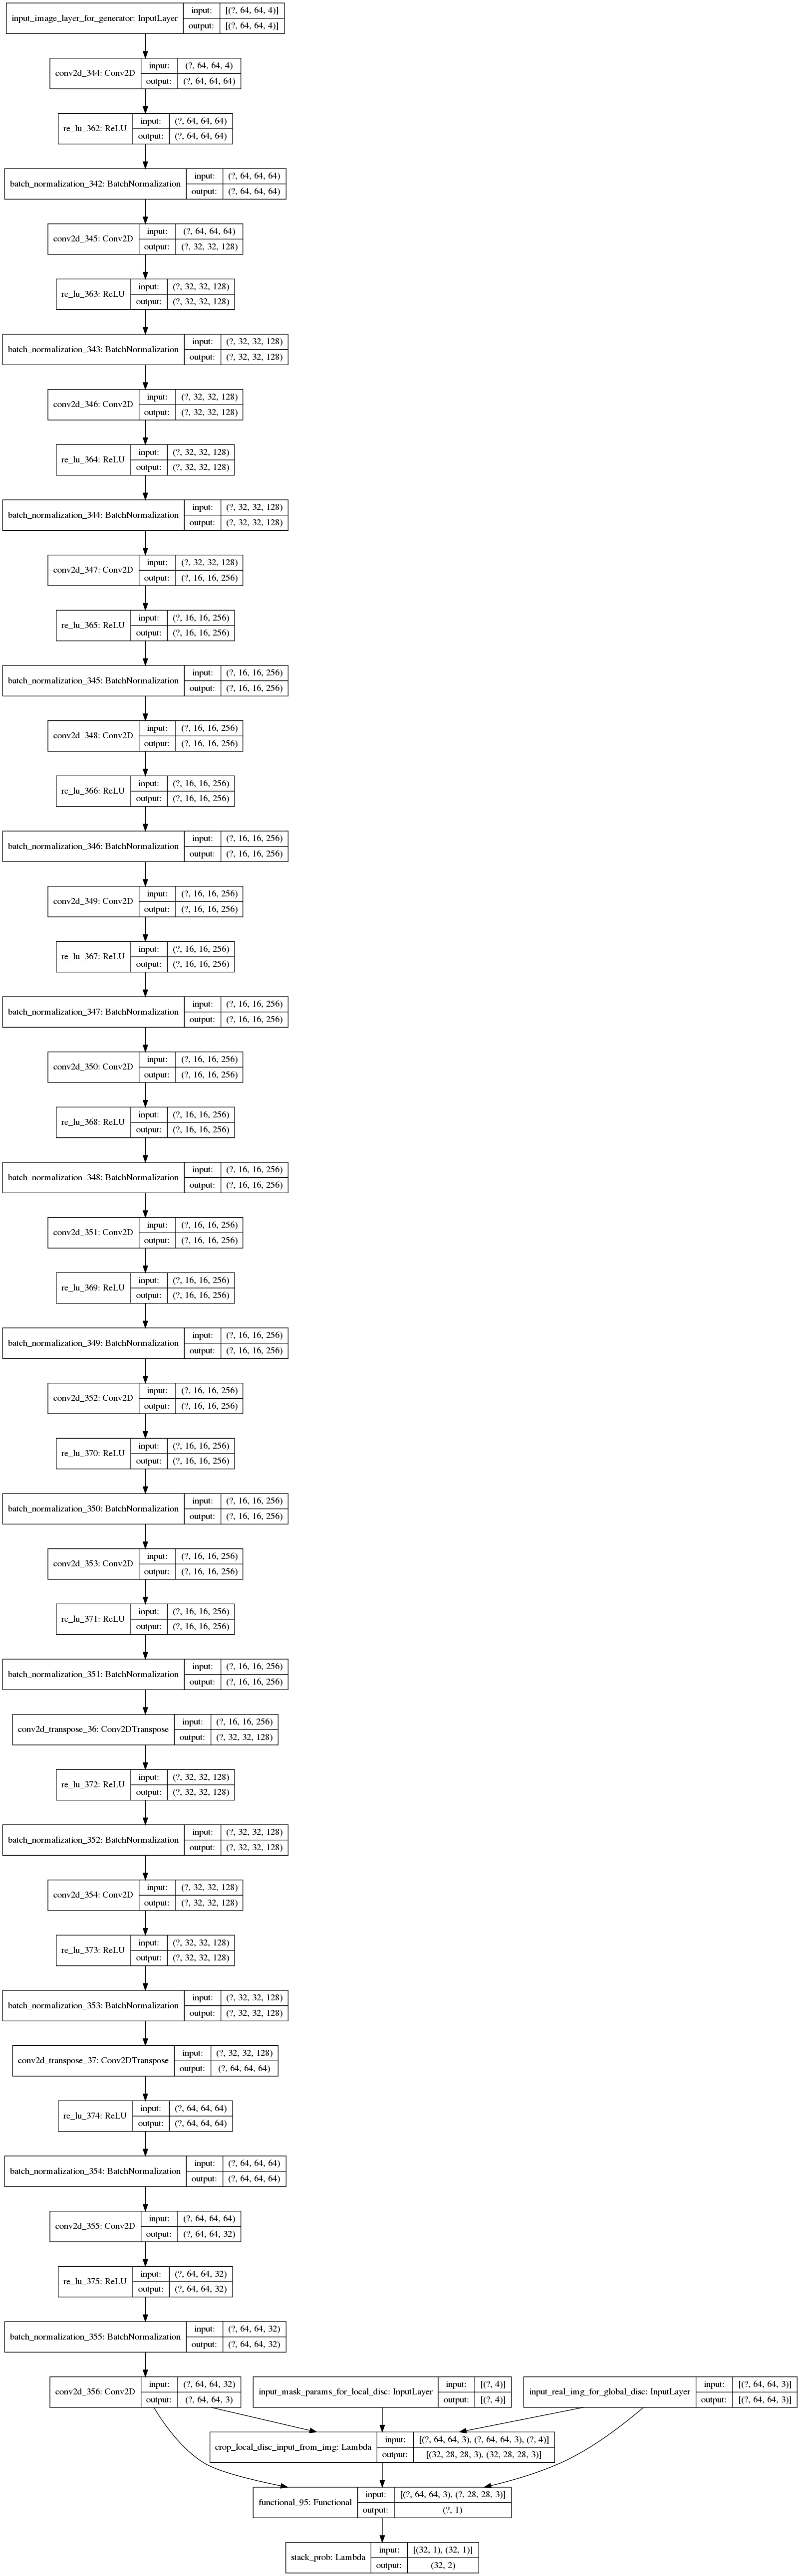

In [35]:
plot_model(net.modelForTrainOnlyGenWithJoint, to_file='modelForTrainOnlyGenWithJoint.png', show_shapes=True, show_layer_names=True)

In [37]:
net.modelForTrainOnlyGenWithJoint.outputs

[<tf.Tensor 'conv2d_356/BiasAdd:0' shape=(None, 64, 64, 3) dtype=float32>,
 <tf.Tensor 'stack_prob/Squeeze_10:0' shape=(32, 2) dtype=float32>]

In [40]:
net = GANScape(32)

net.compileAll()
#net.modelForTrainOnlyGenWithMSE
#net.modelForTrainOnlyDisc
#net.modelForTrainOnlyGenWithJoint

epochs = 1
batchSize = 32
numOfAllTrainDataSample = 172703
stepsPerEpoch = numOfAllTrainDataSample // batchSize
numOfBatchesLoadedAtOnce = 100

phaseOneRatio = 0.33
phaseTwoRatio = 0.33
tC = int(phaseOneRatio * stepsPerEpoch)
tD = int(phaseTwoRatio * stepsPerEpoch)

trainData = DataRead(r'/media/gamma/TOSHIBA EXT/DL/places_64x64/','train', batchSize, numOfBatchesLoadedAtOnce)
dummyLabels = np.empty((batchSize, 2))

for epoch in range(epochs):
    #------------------------------------------TRAINING-------------------------------------
    counterInBatches = 0
    t = 0
    while t < stepsPerEpoch:
        if counterInBatches == numOfBatchesLoadedAtOnce:
            counterInBatches = 0
            trainData.reset()
            
        if t < tC:
            # ---------------------
            #  PHASE ONE, train only Generatort with weighted MSE
            # ---------------------
            ret = net.modelForTrainOnlyGenWithMSE.train_on_batch(
                x = trainData[counterInBatches].cropped_images,
                y = trainData[counterInBatches].target_images)
            print(f"---Epoch {epoch} --- Step {t} --- PHASE I --- mse_loss={ret}")

        elif t < (tC + tD):
            # ---------------------
            #  PHASE TWO, train only Discriminator with binary crossentropy
            # ---------------------
            ret = net.modelForTrainOnlyDisc.train_on_batch(
                x = [trainData[counterInBatches].cropped_images, trainData[counterInBatches].csv, trainData[counterInBatches].target_images],
                y = dummyLabels)
            print(f"---Epoch {epoch} --- Step {t} --- PHASE II --- disc_adversarial_loss={ret}")

        else:
            # ---------------------
            #  PHASE THREE, train Generator with joint loss + Discriminator with binary crossentropy
            # ---------------------
            retD = net.modelForTrainOnlyGenWithJoint.train_on_batch(
                x=[trainData[counterInBatches].cropped_images, trainData[counterInBatches].csv, trainData[counterInBatches].target_images],
                y=[trainData[counterInBatches].target_images, dummyLabels])
            
            retG = net.modelForTrainOnlyDisc.train_on_batch(
                x = [trainData[counterInBatches].cropped_images, trainData[counterInBatches].csv, trainData[counterInBatches].target_images],
                y = dummyLabels)
            
            print(f"---Epoch {epoch} --- Step {t} --- PHASE III --- disc_adversarial_loss={retD} --- mse_loss={ret[0]}, gen_adversarial_loss={ret[1]}")
        
        t += 1
        counterInBatches += 1
    #------------------------------------------------VALIDATION-------------------------------------
    """
    validationData = DataRead(r'/media/gamma/TOSHIBA EXT/DL/places_64x64/','valid', batchSize, numOfBatchesLoadedAtOnce)
    
    retGMSE = net.modelForTrainOnlyGenWithMSE.evaluate(
                x=validationData.cropped_images,
                y=validationData.target_images,
                batch_size=batchSize,
                verbose=1)
    
    retD = net.modelForTrainOnlyDisc.evaluate(
                x=validationData.cropped_images,
                y=validationData.target_images,
                batch_size=batchSize,
                verbose=1)
    
    retGJoint = net.modelForTrainOnlyGenWithJoint.evaluate(
                x=validationData.cropped_images,
                y=validationData.target_images,
                batch_size=batchSize,
                verbose=1)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-40-a94a0c2f8312>, line 73)

In [8]:
trainData = DataRead(r'/media/gamma/TOSHIBA EXT/DL/places_64x64/','train',32,1)#path, mode, batch size, batch num  folder_path, data_type, batch_size, batch_num)
#validData = DataRead(r'/media/gamma/TOSHIBA EXT/DL/places_64x64/','valid',25,5)#path, mode, batch size, batch num  folder_path, data_type, batch_size, batch_num)
#testData = DataRead(r'/media/gamma/TOSHIBA EXT/DL/places_64x64/','test',25,5)#path, mode, batch size, batch num  folder_path, data_type, batch_size, batch_num)

172703
172703
172703


In [16]:
print("trainData.target_images.shape", trainData.target_images.shape)
print("trainData.cropped_images.shape", trainData.cropped_images.shape)
print("trainData.crop_images.shape", trainData.crop_images)
print("trainData.csv.shape", trainData.csv)

trainData.target_images.shape (1, 32, 64, 64, 3)
trainData.cropped_images.shape (1, 32, 64, 64, 3)
trainData.crop_images.shape [[array([[[ 96,  84,  94],
        [ 77,  65,  69],
        [ 75,  62,  54],
        ...,
        [195, 184, 152],
        [204, 189, 166],
        [195, 180, 157]],

       [[107,  94, 101],
        [ 60,  46,  45],
        [101,  87,  76],
        ...,
        [201, 186, 153],
        [198, 183, 160],
        [192, 177, 154]],

       [[ 74,  60,  59],
        [ 83,  68,  61],
        [ 78,  60,  46],
        ...,
        [203, 183, 150],
        [211, 197, 171],
        [209, 195, 169]],

       ...,

       [[ 38,  41,  60],
        [ 44,  47,  66],
        [ 42,  44,  59],
        ...,
        [174, 169, 166],
        [179, 168, 166],
        [183, 172, 170]],

       [[ 33,  36,  55],
        [ 34,  37,  56],
        [ 29,  31,  46],
        ...,
        [178, 173, 170],
        [180, 169, 167],
        [183, 172, 170]],

       [[ 41,  44,  63],
        

In [23]:
trainData.crop_images[0][1].shape

(19, 18, 3)

In [ ]:
import cv2
#a = cv2.imread('/media/gamma/TOSHIBA EXT/DL/1.png')
a = cv2.imread(r'\\media\\gamma\\TOSHIBA EXT\\DL\\1.png')
a.shape
cv2.imshow('img',a)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
trainData.csv[0][15]

[52, 48, 126, 121]